In [1]:
from tunekit import *

import json

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from colorama import Back

import peft
from datasets import Dataset, concatenate_datasets
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

/home/tejpaper/workspace/pets/ongoing/kotlin-completion/tunekit/dataset.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
sns.set_style('white')

# Model selection

A programmer often has to return to already written lines of code and correct them, add new ones between the existing ones. So the future context can also be useful in the task of code completion. Therefore, as an experiment it was decided to adapt the decoder-only model for the task of mask filling.

Phi-1 was chosen as the basis, which, unlike Phi-1.5, has a less natural language bias. Then the attention masks that limit the model's access to the future were removed. An additional mask token was also introduced, which embedding was trained as fine tuning was performed. The classification head is now only applied by mask position.

All code related to model adaptation is in the `model.py` module in the `tunekit` package.

# Data

A corpus was obtained from the [Kotlin repository](https://github.com/JetBrains/kotlin) from GitHub. For more details see `data/README.md`.

Data preparation consisted of several parts. First, character-based boolean masks were created to indicate the possibility of choosing a given symbol as the one from which to start solving the code completion problem. Comment characters and tabulation at the beginning of lines were ignored. This was done so that the Transformer would not learn to model unnecessary data. Examples of such masks are demonstrated below. These masks were then used to randomly select lines of code that were replaced with the mask token. So the model was trained to predict a single token in the middle of the text. Next comes tokenization. For more details see `tunekit/dataset.py`.

In [3]:
python_test_df = pd.read_csv(PYTHON_TEST_CSV,  usecols=['code'])
kotlin_test_df = pd.read_csv(KOTLIN_TEST_CSV,  usecols=['code'])

In [4]:
python_test_df = precalculate_masks_positions(python_test_df, python_ignore_chars)
kotlin_test_df = precalculate_masks_positions(kotlin_test_df, kotlin_ignore_chars)

Precalculating masks positions:   0%|          | 0/50000 [00:00<?, ?it/s]

Precalculating masks positions:   0%|          | 0/20000 [00:00<?, ?it/s]

In [5]:
def apply_mask(code: str, mask_positions: np.ndarray) -> str:
    result = ''
    
    for i, char in enumerate(code):
        if i in mask_positions:
            result += Back.GREEN + char + Back.RESET
        else:
            result += char
    
    return result

In [6]:
sample_idx = 129
print(apply_mask(*python_test_df.iloc[sample_idx]))

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# vim: set hls is et sw=4 sts=4 ts=8:

import os
from setuptools import setup, find_packages


with open(os.path.join(os.path.dirname(__file__), 'requirements.txt')) as f:
    required = f.read().splitlines()

setup(
    name='mass',
    version='0.1.0',
    description='Computer Farm Management',
    author='',
    author_email='',
    packages=find_packages(exclude=['docs', 'contrib', 'tests*']),
    include_package_data=True,
    setup_requires=[
        'versiontools >= 1.8',
    ],
    install_requires=required,
    entry_points={
        'console_scripts': [
            'mass = mass.cli:cli',
        ],
    },
)

del required



In [7]:
sample_idx = 4
print(apply_mask(*kotlin_test_df.iloc[sample_idx]))

// SKIP_INLINE_CHECK_IN: inlineFun$default
// WITH_STDLIB
// TARGET_BACKEND: JVM
// FILE: 1.kt
package test

class OK
class FAIL

inline fun <reified T> inlineFun(lambda: () -> String = { T::class.java.simpleName }): String {
    return lambda()
}

inline fun <reified T> inlineFun2(): String {
    return inlineFun<OK>()
}

// FILE: 2.kt

import test.*

fun box(): String {
    return inlineFun2<FAIL>()
}



# Metrics

Four metrics and one loss function were used to estimate the model performance:

1. Top-1 accuracy (main)
2. top-5 accuracy
3. Top-20 accuracy
4. Top-100 accuracy
5. Cross entropy loss

For more details see `tunekit/eval.py`.

# Fine-tuning

QLoRA with four bit quantization was used for fine-tuning. For more details see the `train` folder and the `tunekit/train.py` module.

# Results

The results are presented below with some additional comments.

In [8]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/phi-1', trust_remote_code=True)
_ = tokenizer.add_special_tokens(dict(mask_token=MASK_TOKEN, pad_token=tokenizer.eos_token))

In [9]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
)
model = AutoModelForCausalLM.from_pretrained(
    'microsoft/phi-1',
    device_map='auto',
    use_cache=False,
    quantization_config=bnb_config,
)
model = set_model_mode(model)
model = adapt_phi(model, tokenizer.mask_token_id)

In [10]:
preprocessing_test = Preprocessing(tokenizer, randomize=False, random_seed=RANDOM_SEED)

split_index = len(python_test_df) // 2
python_test_ds = concatenate_datasets([
    Dataset.from_pandas(python_test_df.iloc[:split_index], preserve_index=False),
    Dataset.from_pandas(python_test_df.iloc[split_index:], preserve_index=False)
])
python_test_ds.set_transform(preprocessing_test.transform)

kotlin_test_ds = Dataset.from_pandas(kotlin_test_df, preserve_index=False)
kotlin_test_ds.set_transform(preprocessing_test.transform)

In [11]:
kotlin_baseline = evaluate(model, kotlin_test_ds, cache_file=KOTLIN_BASELINE)
kotlin_baseline

[MeanCrossEntropy(10.8354),
 TopKAccuracy(0.0282, k=1),
 TopKAccuracy(0.0805, k=5),
 TopKAccuracy(0.1525, k=20),
 TopKAccuracy(0.2701, k=100)]

In [12]:
python_baseline = evaluate(model, python_test_ds, cache_file=PYTHON_BASELINE)
python_baseline

[MeanCrossEntropy(10.7693),
 TopKAccuracy(0.0316, k=1),
 TopKAccuracy(0.0921, k=5),
 TopKAccuracy(0.1667, k=20),
 TopKAccuracy(0.2781, k=100)]

The results of the original model are very weak. This is easily explained by the fact that the model from decoder-only architecture was converted to encoder-only.

In [13]:
lora_model = peft.PeftModel.from_pretrained(model, MODEL_DIR, from_transformers=True)
lora_model = set_model_mode(lora_model)

In [14]:
kotlin_tuned = evaluate(model, kotlin_test_ds, cache_file=KOTLIN_TUNED)
kotlin_tuned

[MeanCrossEntropy(3.9759),
 TopKAccuracy(0.2694, k=1),
 TopKAccuracy(0.4970, k=5),
 TopKAccuracy(0.6779, k=20),
 TopKAccuracy(0.8526, k=100)]

In [15]:
python_tuned = evaluate(model, python_test_ds, cache_file=PYTHON_TUNED)
python_tuned

[MeanCrossEntropy(4.8390),
 TopKAccuracy(0.1913, k=1),
 TopKAccuracy(0.3847, k=5),
 TopKAccuracy(0.5643, k=20),
 TopKAccuracy(0.7558, k=100)]

In [16]:
metric_order = ['Cross Entropy Loss', 'Top-1 Accuracy']
metrics = pd.DataFrame(
    {'language': 2 * ['Kotlin', 'Python']} |
    {'model': 2 * ['Baseline'] + 2 * ['Tuned']} |
    {metric: [report[i].value * (100 if 'Accuracy' in metric else 1)
              for report in (kotlin_baseline,
                             python_baseline,
                             kotlin_tuned,
                             python_tuned)
              ] for i, metric in enumerate(metric_order)})
metrics = pd.melt(metrics, id_vars=['language', 'model'], var_name='metric', value_name='value')

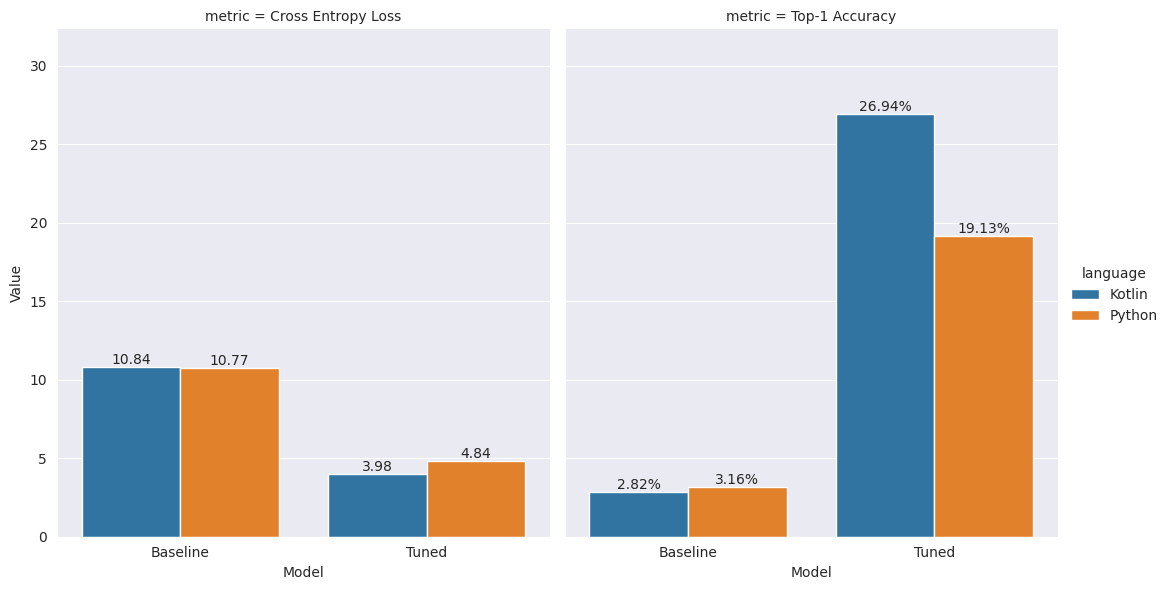

In [17]:
with sns.axes_style('darkgrid'):
    metrics_plot = sns.catplot(
        data=metrics, 
        x='model', 
        y='value', 
        hue='language', 
        col='metric', 
        kind='bar',
        legend=True, 
        height=6,
        aspect=0.9,
    )
metrics_plot.set_xlabels('Model')
metrics_plot.set_ylabels('Value')

for metric, ax in zip(metric_order, metrics_plot.axes.ravel()):
    for cont in ax.containers:
        labels = [f'{rect.get_height():.02f}' + ('%' if 'Accuracy' in metric else '') for rect in cont]
        ax.bar_label(cont, labels=labels, label_type='edge')
    ax.margins(y=0.2)

We can observe the growth of metrics not only on Kotlin code, but also on Python. The same explanation applies here, that the model has “learned to be” an encoder.

Now let's look at the learning curves.

In [18]:
logs_file = os.path.join(MODEL_DIR, 'last_trainer_state.json')
with open(logs_file) as file:
    logs = json.load(file)

In [19]:
train_logs = pd.DataFrame(logs['log_history'][::2])
eval_logs = pd.DataFrame(logs['log_history'][1::2])

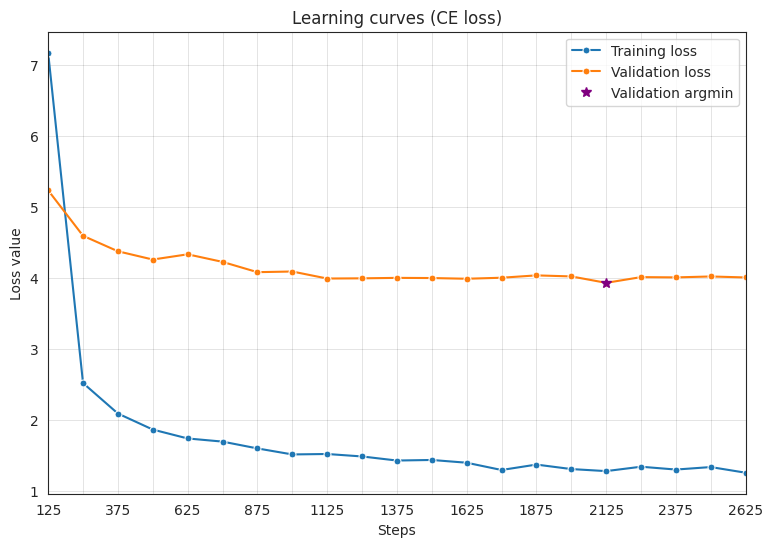

In [20]:
_, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(x=train_logs.step,
             y=train_logs.loss, 
             marker='o', 
             ms=5,
             label='Training loss',
             ax=ax)
sns.lineplot(x=eval_logs.step,
             y=eval_logs.eval_loss, 
             marker='o',
             ms=5,
             label='Validation loss',
             ax=ax)
argmin = eval_logs.eval_loss.argmin()
ax.plot(eval_logs.step[argmin],
        eval_logs.eval_loss[argmin], 
        marker='*', 
        color='purple',
        label='Validation argmin',
        linestyle='None',
        ms=7)

locator = ticker.FixedLocator(train_logs.step)
ax.xaxis.set_major_locator(locator)
ax.set_xlim(train_logs.step.min(), train_logs.step.max())
ax.set_xticks(train_logs.step[::2])
ax.set_xticks(train_logs.step, minor=True)
ax.grid(axis='x', which='both', color='black', alpha=0.15, linewidth=0.5)

ax.grid(axis='y', color='black', alpha=0.15, linewidth=0.5)

ax.set_title('Learning curves (CE loss)')
ax.set_xlabel('Steps')
ax.set_ylabel('Loss value')
_ = ax.legend()

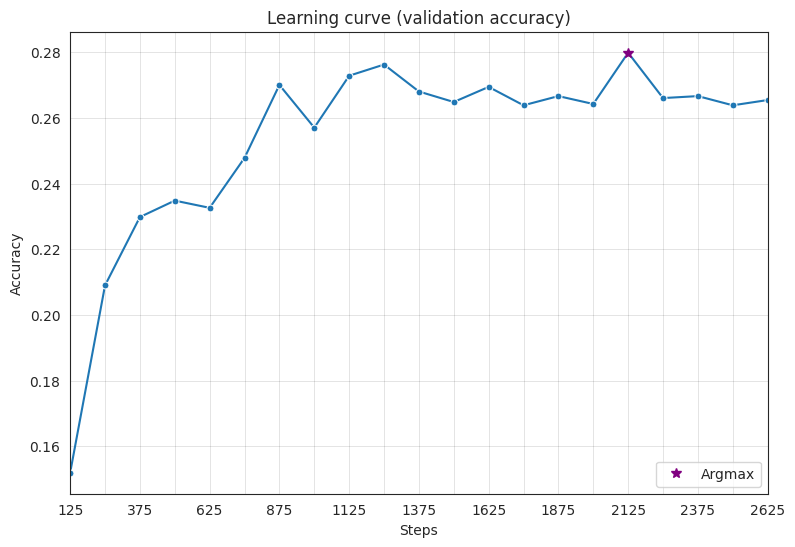

In [21]:
_, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(x=eval_logs.step, 
             y=eval_logs.eval_top_1_accuracy,
             marker='o',
             ms=5,
             ax=ax)
argmax = eval_logs.eval_top_1_accuracy.argmax()
ax.plot(eval_logs.step[argmax],
        eval_logs.eval_top_1_accuracy[argmax],
        marker='*',
        color='purple',
        label='Argmax',
        linestyle='None',
        ms=7)

locator = ticker.FixedLocator(train_logs.step)
ax.xaxis.set_major_locator(locator)
ax.set_xlim(train_logs.step.min(), train_logs.step.max())
ax.set_xticks(train_logs.step[::2])
ax.set_xticks(train_logs.step, minor=True)
ax.grid(axis='x', which='both', color='black', alpha=0.15, linewidth=0.5)

ax.grid(axis='y', color='black', alpha=0.15, linewidth=0.5)

ax.set_title('Learning curve (validation accuracy)')
ax.set_xlabel('Steps')
ax.set_ylabel('Accuracy')
_ = ax.legend(loc='lower right')

# Beam search

The model predicts one token at a time. To accomplish the line completion task, code is provided to implement beam search. This approach improves the results of the model. To switch to classical token-to-token prediction, you can specify `beam_width=1`. See `tunekit/pipeline.py` for more details.

In [22]:
pipeline = MaskFillingBeamSearch(model=lora_model, tokenizer=tokenizer)

In [23]:
trivial_sample = '''
fun sum_two_numbers(x: Int, y: Int): Int {
    return <|mask|>
}
'''.replace(tokenizer.mask_token + '\n', tokenizer.mask_token)[1:]

In [24]:
trivial_sample_output = pipeline(trivial_sample, max_search_depth=8)

  0%|          | 0/8 [00:00<?, ?it/s]

In [25]:
print(trivial_sample_output.filled_string[0])

fun sum_two_numbers(x: Int, y: Int): Int {
    return x + y
}



In [26]:
# https://github.com/JetBrains/kotlin/blob/master/compiler/testData/codegen/box/jvmField/diamond.kt
# ground truth is ".okay()\n"
okay_sample = '''
// TARGET_BACKEND: JVM

// FILE: A.java
public interface A { public String ok = "OK"; }
// FILE: B.java
public class B implements A {}
// FILE: C.java
public class C extends B implements A {}
// FILE: test.kt
class D: C() {
    fun okay() = ok
}

fun box() = D().<|mask|>
'''.replace(tokenizer.mask_token + '\n', tokenizer.mask_token)[1:]

In [27]:
okay_sample_output = pipeline(okay_sample, max_search_depth=8)

  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
print(okay_sample_output.filled_string[0])

// TARGET_BACKEND: JVM

// FILE: A.java
public interface A { public String ok = "OK"; }
// FILE: B.java
public class B implements A {}
// FILE: C.java
public class C extends B implements A {}
// FILE: test.kt
class D: C() {
    fun okay() = ok
}

fun box() = D().ok {}



In [29]:
# https://github.com/JetBrains/kotlin/blob/master/compiler/psi/src/org/jetbrains/kotlin/psi/stubs/impl/KotlinParameterStubImpl.kt
# ground truth is " Boolean,\n"
look_ahead_sample = '''
/*
 * Copyright 2010-2015 JetBrains s.r.o.
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 * http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

package org.jetbrains.kotlin.psi.stubs.impl

import com.intellij.psi.stubs.StubElement
import com.intellij.util.io.StringRef
import org.jetbrains.kotlin.psi.KtParameter
import org.jetbrains.kotlin.psi.stubs.KotlinParameterStub
import org.jetbrains.kotlin.psi.stubs.elements.KtStubElementTypes
import org.jetbrains.kotlin.name.FqName
import com.intellij.psi.PsiElement

class KotlinParameterStubImpl(
    parent: StubElement<out PsiElement>?,
    private val fqName: StringRef?,
    private val name: StringRef?,
    private val isMutable:<|mask|>
    private val hasValOrVar: Boolean,
    private val hasDefaultValue: Boolean,
    val functionTypeParameterName: String? = null
) : KotlinStubBaseImpl<KtParameter>(parent, KtStubElementTypes.VALUE_PARAMETER), KotlinParameterStub {

    override fun getName(): String? {
        return StringRef.toString(name)
    }

    override fun getFqName(): FqName? {
        return if (fqName != null) FqName(fqName.string) else null
    }

    override fun isMutable() = isMutable
    override fun hasValOrVar() = hasValOrVar
    override fun hasDefaultValue() = hasDefaultValue
}
'''.replace(tokenizer.mask_token + '\n', tokenizer.mask_token)[1:]

In [30]:
look_ahead_sample_output = pipeline(look_ahead_sample, max_search_depth=8)

  0%|          | 0/8 [00:00<?, ?it/s]

In [31]:
print(look_ahead_sample_output.filled_string[0])

/*
 * Copyright 2010-2015 JetBrains s.r.o.
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 * http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 */

package org.jetbrains.kotlin.psi.stubs.impl

import com.intellij.psi.stubs.StubElement
import com.intellij.util.io.StringRef
import org.jetbrains.kotlin.psi.KtParameter
import org.jetbrains.kotlin.psi.stubs.KotlinParameterStub
import org.jetbrains.kotlin.psi.stubs.elements.KtStubElementTypes
import org.jetbrains.kotlin.name.FqName
import com.intellij.psi.PsiElement

class KotlinParameterStubImpl

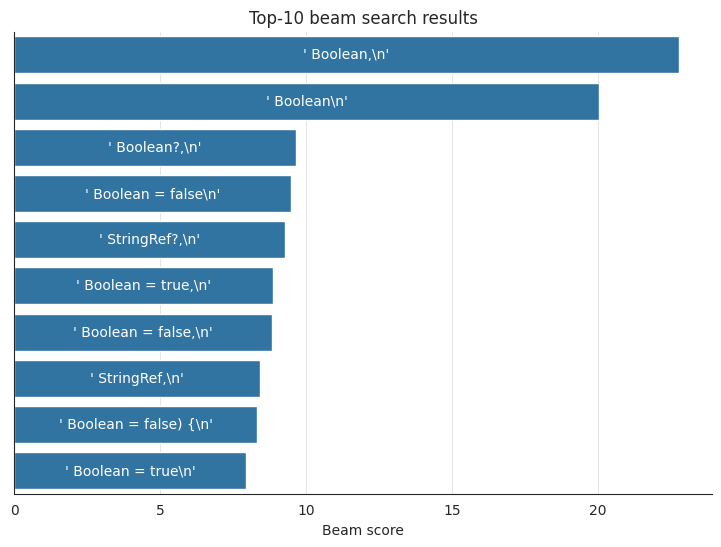

In [32]:
n_top_samples = 10
_, ax = plt.subplots(figsize=(9, 6))

sns.barplot(y=range(n_top_samples),
            x=look_ahead_sample_output.scores[:n_top_samples],
            orient='h',
            ax=ax)
ax.bar_label(ax.containers[0],
             label_type='center',
             color='white',
             labels=map(repr, look_ahead_sample_output.completions[:n_top_samples]))

ax.set_title(f'Top-{n_top_samples} beam search results')
ax.set_xlabel('Beam score')
ax.set_yticks([])
ax.grid(axis='x', color='black', alpha=0.15, linewidth=0.5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The ordinary mean of the logarithm of the probabilities was replaced by the ratio of this measure of the untrained model to that of the trained model. That is, scores can be interpreted as follows: how many times this prediction is better than a random one.

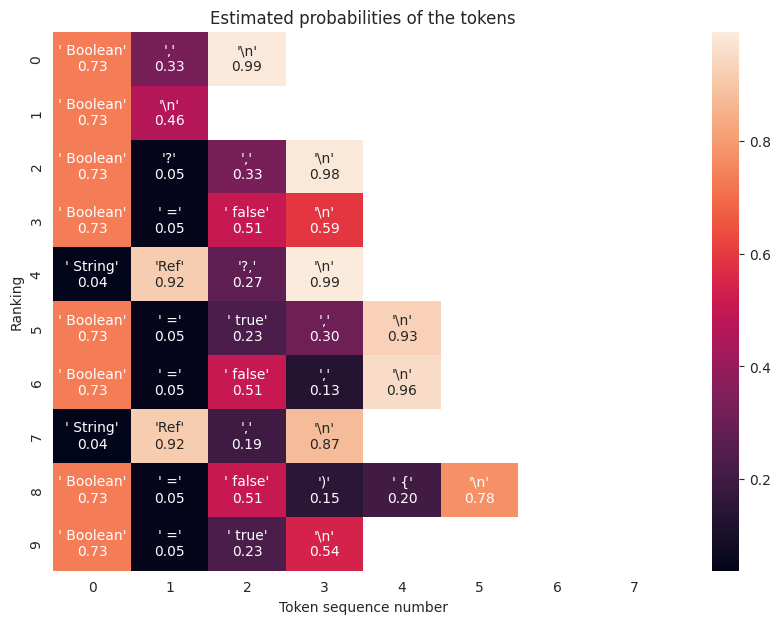

In [33]:
_, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(
    look_ahead_sample_output.tokens_probs[:n_top_samples],
    annot=[[f'{repr(tokenizer.decode(token_id))}\n{prob:.02f}' for token_id, prob in zip(sample, probs)]
           for sample, probs in zip(
            look_ahead_sample_output.completion_tokens[:n_top_samples],
            look_ahead_sample_output.tokens_probs[:n_top_samples]
        )],
    fmt='',
    ax=ax,
)

ax.set_title(f'Estimated probabilities of the tokens')
ax.set_xlabel('Token sequence number')
_ = ax.set_ylabel('Ranking')

# Conclusion

The considered model is **not** sufficient for solving the task at hand. Its low accuracy and high cost of use contribute to this conclusion. Therefore, I suggest possible improvements and options for further development of this solution:

1. Training the model from scratch for Kotlin code completion. This in turn will allow to experiment with the lightness of the new model.
2. In addition to raw code, the model can be fed with information about its structure (whether a token is part of a comment/variable/function, etc.).
3. The previous point also applies to file names and the structure of the project as a whole.
4. Try to feed absolute positional embeddings instead of relative ones.

It should also be noted that due to computational complexity and lack of resources, only one set of hyperparameters was tried. This could also be a source of possible improvements.